In [97]:
import numpy as np
from math import pi, sqrt, tanh
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from scipy.optimize import minimize
import time
from ipywidgets import interact

hbar=1.05e-34
elec=1.6e-19
meV=elec*1e-3

In [98]:
# newest parameters

vF=1e6
B=6 # Tesla
hwc=vF*sqrt(2*hbar*elec*B)
lB=np.sqrt(hbar/(elec*B))
m_sc=3*hwc 
mu_sc=0*hwc 
m_n=0.06*hwc 

gn=0.1*hwc 
nu=0
mu_n=nu*hwc # chemical potential in QH

Ls=6*lB
Lx=8*lB
# print(Ls*1e9,6/3.5,hwc/elec*1e3)

In [99]:
# vF=1e6
# B=10 # Tesla
# hwc=vF*sqrt(2*hbar*elec*B)
# lB=np.sqrt(hbar/(elec*B)) # magnetic length
# m_sc=3*hwc  # mass term to get quadratic dispersion inside sc
# mu_sc=0*hwc # chemical potential of vaccum inside the gap
# nu=0.3 
# mu_n=nu*hwc # chemical potential in QH
# m_n=0.1*hwc # small mass to lift N=0 LL degeneracy of graphene 

# # Zeeman splitting
# gn=0.3*hwc # inside QH


Nk=201 # number of k points 
kmax=4/lB # max abs of k
ky_sw=np.linspace(-kmax,kmax,Nk)

# Ls=8*lB # width of sc
# Lx=8*lB
Nx=200 # number of plane waves, don't make this too big, the H matrix to be diagonalized is 16Nx by 16Nx 
kx=2*pi*np.arange(Nx)/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls)
[k1,k2]=2*pi*np.mgrid[range(Nx),range(Nx)]/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls)



def y2(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c= np.exp(1j*k*Ls/2)*(-2j+np.exp(1j*k*Lx)*(2j+ 2*k*Lx- 1j* k**2 * Lx**2))/ (k**3) /(2*Lx+Ls)
        c[ ~ np.isfinite( c )] = Lx**3 /(3*(2*Lx+Ls))
    return c

def y1(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.exp(1j*k*Ls/2)*(-1+np.exp(1j*k*Lx)*(1- 1j* k * Lx))/ (k**2) /(2*Lx+Ls)
        c[ ~ np.isfinite( c )] = Lx**2 /(2*(2*Lx+Ls))
    return c

def y0(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = -1j*np.exp(1j*k*Ls/2)*(-1+np.exp(1j*k*Lx) )/(k*(2*Lx+Ls))
        c[ ~ np.isfinite( c )] = Lx /(2*Lx+Ls)
    return c

def y0s(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = 2*np.sin(k*Ls/2)/(k*(2*Lx+Ls))
        c[ ~ np.isfinite( c )] = Ls /(2*Lx+Ls)
    return c

sigma0=np.array([[1,0],[0,1]])
sigma1=np.array([[0,1],[1,0]])
sigma2=np.array([[0,-1j],[1j,0]])
sigma3=np.array([[1,0],[0,-1]])

Hx= hbar*vF*np.kron(sigma3, np.kron(np.diag(kx) , sigma1))
HeB= 2j*vF*elec*B* np.kron(np.imag(y1(k1-k2)), sigma2)

Hxm= np.kron( m_sc*y0s(k1-k2)+2*m_n*np.real(y0(k1-k2)) , sigma3)

Hef= -np.kron( 2*mu_n*np.real(y0(k1-k2)) + mu_sc*y0s(k1-k2), sigma0 )

Vn=np.zeros((4*Nx,4*Nx,len(ky_sw)), dtype=np.complex64)
En=np.zeros((4*Nx,len(ky_sw)))
for i_y in range(len(ky_sw)):
    ky=ky_sw[i_y]
    Hy= hbar*vF*ky*np.kron(np.eye(Nx), sigma2)

    H_t = Hx + np.kron(sigma0, Hy+ HeB + Hxm + Hef)
    En[:,i_y], Vn[:,:,i_y] =np.linalg.eigh(H_t)


print("Done!")

Done!


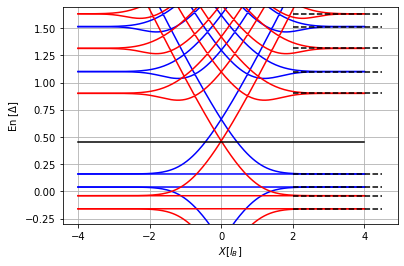

In [100]:
plt.figure()
# plt.plot(ky_sw*lB,En[:199,:].T/hwc,'b')
# plt.plot(ky_sw*lB,En[201:,:].T/hwc,'b')
plt.plot(ky_sw*lB,En[:199,:].T/hwc+gn/hwc,'b')
plt.plot(ky_sw*lB,En[201:,:].T/hwc+gn/hwc,'b')
plt.plot(ky_sw*lB,En[:199,:].T/hwc-gn/hwc,'r')
plt.plot(ky_sw*lB,En[201:,:].T/hwc-gn/hwc,'r')
plt.ylabel(r"En [$\Delta$]")
plt.xlabel(r"$X[l_B]$")

Nll=4
ill=np.arange(Nll)
E1=np.reshape(np.sqrt(ill+(m_n/hwc)**2),[1,Nll])
Eplot= np.concatenate((E1,E1),axis=0)
xvals=np.reshape(np.array([2,4.5]),[2,1])
plt.plot(xvals, Eplot-mu_n/hwc-gn/hwc,'k--')
plt.plot(xvals, Eplot-mu_n/hwc+gn/hwc,'k--')
plt.plot(xvals, -Eplot+mu_n/hwc-gn/hwc,'k--')
plt.plot(xvals, -Eplot+mu_n/hwc+gn/hwc,'k--')

nu=0.45
plt.plot(ky_sw*lB,ky_sw*lB*0+nu,'k')

# plt.ylim(-22,22)
# plt.ylim(-0.015,0.015)
plt.ylim(-0.3,1.7)
plt.grid()

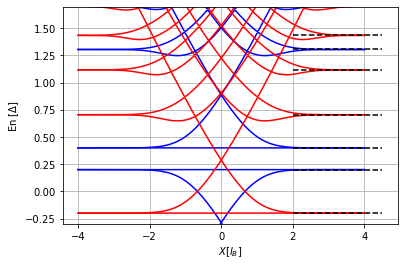

In [53]:
plt.figure()
# plt.plot(ky_sw*lB,En[:199,:].T/hwc,'b')
# plt.plot(ky_sw*lB,En[201:,:].T/hwc,'b')
plt.plot(ky_sw*lB,En[:199,:].T/hwc+gn/hwc,'b')
plt.plot(ky_sw*lB,En[201:,:].T/hwc+gn/hwc,'b')
plt.plot(ky_sw*lB,En[:199,:].T/hwc-gn/hwc,'r')
plt.plot(ky_sw*lB,En[201:,:].T/hwc-gn/hwc,'r')
plt.ylabel(r"En [$\Delta$]")
plt.xlabel(r"$X[l_B]$")

Nll=4
ill=np.arange(Nll)
E1=np.reshape(np.sqrt(ill+(m_n/hwc)**2),[1,Nll])
Eplot= np.concatenate((E1,E1),axis=0)
xvals=np.reshape(np.array([2,4.5]),[2,1])
plt.plot(xvals, Eplot-mu_n/hwc-gn/hwc,'k--')
plt.plot(xvals, Eplot-mu_n/hwc+gn/hwc,'k--')
plt.plot(xvals, -Eplot+mu_n/hwc-gn/hwc,'k--')
plt.plot(xvals, -Eplot+mu_n/hwc+gn/hwc,'k--')


# plt.ylim(-22,22)
# plt.ylim(-0.015,0.015)
plt.ylim(-0.3,1.7)
plt.grid()

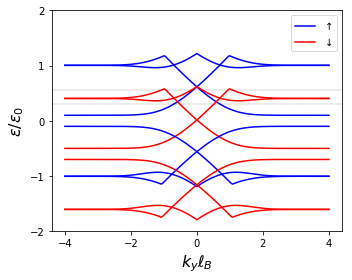

In [9]:
######### plot for the notes

ix=4

plt.figure(figsize=(5,4))
plt.plot(ky_sw*lB,En[2*Nx+1,:].T/hwc+gn/hwc,'b',label=r'$\uparrow$')
plt.plot(ky_sw*lB,En[2*Nx+1,:].T/hwc-gn/hwc,'r',label=r'$\downarrow$')
plt.plot(ky_sw*lB,En[2*Nx-ix:2*Nx-1,:].T/hwc+gn/hwc,'b')
plt.plot(ky_sw*lB,En[2*Nx+2:2*Nx+ix,:].T/hwc+gn/hwc,'b')
plt.plot(ky_sw*lB,En[2*Nx-ix:2*Nx-1,:].T/hwc-gn/hwc,'r')
plt.plot(ky_sw*lB,En[2*Nx+2:2*Nx+ix,:].T/hwc-gn/hwc,'r')
lw=0.2
plt.plot(2*ky_sw*lB,ky_sw*0+0.3,'k--',linewidth=lw)
plt.plot(2*ky_sw*lB,ky_sw*0+0.55,'k--',linewidth=lw)
fsize=16
plt.ylabel(r"$\varepsilon/\varepsilon_0$",fontsize = fsize)
plt.xlabel(r"$k_y \ell_B$",fontsize = fsize)
plt.ylim(-2,2)
plt.xlim(-4.4,4.4)
# plt.xlim(-1,4)
plt.xticks(np.arange(-4,4.1,2))
plt.yticks(np.arange(-2,2.1,1))
plt.legend(loc='upper right')
plt.tight_layout()
# plt.savefig('figs/TS_Hoppe_particle_m_n.pdf')
plt.show()

